###  Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

### Load Datasets

In [9]:
fraud_data = pd.read_csv('../data/fraud_data.csv')
credit_data = pd.read_csv('../data/creditcard.csv')
ip_country = pd.read_csv('../data/IpAddress_to_Country.csv')

#  Handle Missing Values - fraud_data

In [10]:
print("Missing values before handling:")
print(fraud_data.isnull().sum())

# Simple imputation for numerical columns
fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)

# Drop rows with missing critical fields
fraud_data.dropna(subset=['device_id', 'browser'], inplace=True)

Missing values before handling:
user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64


/var/folders/h5/cqk4jd793hzd58k1ssq6mkd40000gn/T/ipykernel_68203/1931676279.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  fraud_data['age'].fillna(fraud_data['age'].median(), inplace=True)


# Handle Missing Values - creditcard

In [11]:
# Already preprocessed dataset
print("\nCredit data missing values:", credit_data.isnull().sum().sum())


Credit data missing values: 0


# Data Cleaning

In [12]:
# Remove duplicates
fraud_data.drop_duplicates(inplace=True)
credit_data.drop_duplicates(inplace=True)

In [14]:
print(ip_country.columns)

Index(['lower_bound_ip_address', 'upper_bound_ip_address', 'country'], dtype='object')


#  Geolocation Merging

In [16]:
# Convert the 'lower_bound_ip_address' to string before applying .str.split()
ip_country['network'] = ip_country['lower_bound_ip_address'].astype(str).str.split('.').str[0]

# Create network column for fraud_data based on ip_address
fraud_data['network'] = fraud_data['ip_address'].astype(str).str.split('.').str[0]

# Merge country data
fraud_data = fraud_data.merge(
    ip_country[['network', 'country']].drop_duplicates(),
    on='network',
    how='left'
)

#  Feature Engineering & EDA - Basic Analysis

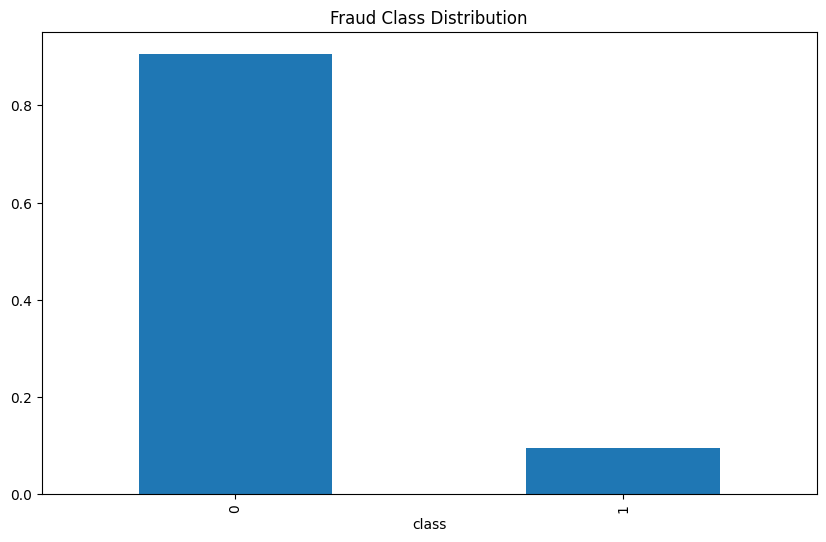

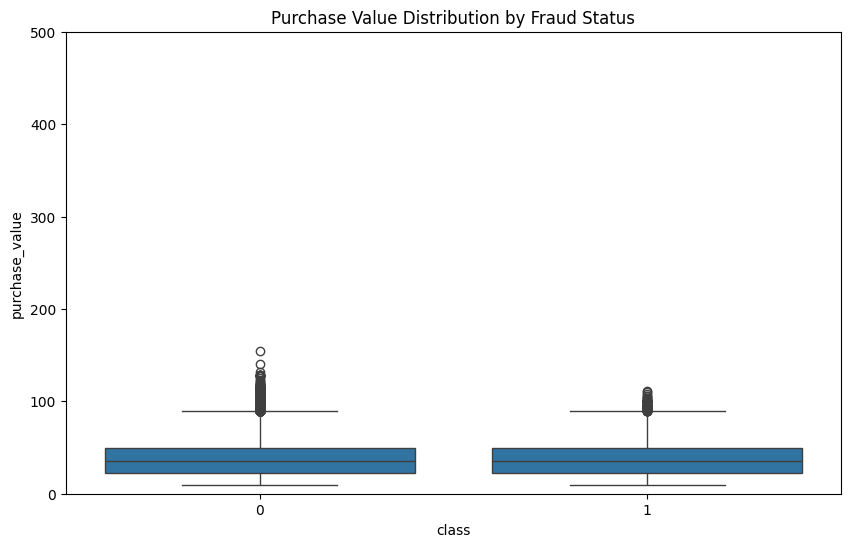

In [6]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace with your actual file path)
fraud_data = pd.read_csv('../data/fraud_data.csv', parse_dates=['signup_time', 'purchase_time'])

# Add a helper column for counting transactions
fraud_data['transaction'] = 1

# Time-based features
fraud_data['purchase_hour'] = fraud_data['purchase_time'].dt.hour
fraud_data['days_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.days

# Transaction frequency: Rolling count of transactions in the last 7 days per user
fraud_data = fraud_data.sort_values(['user_id', 'purchase_time'])  # Sort by user and time
rolling_counts = fraud_data.groupby('user_id').rolling('7D', on='purchase_time')['transaction'].count()
fraud_data['transaction_count_7d'] = rolling_counts.values

# EDA - Basic Analysis
# Fraud class distribution
plt.figure(figsize=(10, 6))
fraud_data['class'].value_counts(normalize=True).plot.bar()
plt.title('Fraud Class Distribution')
plt.show()

# Transaction amounts by fraud status
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='purchase_value', data=fraud_data)
plt.ylim(0, 500)  # Remove outliers for better visualization
plt.title('Purchase Value Distribution by Fraud Status')
plt.show()

# Categorical Encoding

In [13]:
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit

# Assuming your dataset is loaded into a DataFrame called 'fraud_data'
# If not, load it with: fraud_data = pd.read_csv('your_dataset.csv')

# Step 1: Train-Test Split
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in gss.split(fraud_data, groups=fraud_data['user_id']):
    train_data = fraud_data.iloc[train_idx]
    test_data = fraud_data.iloc[test_idx]

# Step 2: Training-Validation Split
gss_val = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_subset_idx, val_idx in gss_val.split(train_data, groups=train_data['user_id']):
    train_subset = train_data.iloc[train_subset_idx]
    val_data = train_data.iloc[val_idx]

# Step 3: Verify the Splits
print(f"Training set shape: {train_subset.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Testing set shape: {test_data.shape}")

# Check for no user overlap (prevents data leakage)
assert len(set(train_subset['user_id']) & set(val_data['user_id'])) == 0, "Overlap between train and validation"
assert len(set(train_subset['user_id']) & set(test_data['user_id'])) == 0, "Overlap between train and test"
assert len(set(val_data['user_id']) & set(test_data['user_id'])) == 0, "Overlap between validation and test"

# Optional: Check unique users
print(f"Unique users in training: {train_subset['user_id'].nunique()}")
print(f"Unique users in validation: {val_data['user_id'].nunique()}")
print(f"Unique users in testing: {test_data['user_id'].nunique()}")

Training set shape: (96711, 15)
Validation set shape: (24178, 15)
Testing set shape: (30223, 15)
Unique users in training: 96711
Unique users in validation: 24178
Unique users in testing: 30223


 # Data Splitting

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset (replace 'path_to_fraud_dataset.csv' with your actual file path)
fraud_data = pd.read_csv('../data/fraud_data.csv')

# Optional: Check the columns to ensure they exist
print(fraud_data.columns)

# Prepare final datasets
X_fraud = fraud_data.drop(['class', 'ip_address', 'signup_time', 'purchase_time'], axis=1)
y_fraud = fraud_data['class']

# Split fraud dataset
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_fraud, y_fraud,
    test_size=0.2,
    stratify=y_fraud,
    random_state=42
)

print("Data preparation complete!")

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class'],
      dtype='object')
Data preparation complete!
